# Assignment 2
**Dylan Osolian & Lisa Samuelsson**

### **Task 1: Working with a dataset with categorical features**
**Step 1: Reading the data**

In [10]:
import pandas as pd
import numpy as np

# training data
training_data = pd.read_csv('./adult_train.csv')

training_data_shuffled = training_data.sample(frac=1.0, random_state=0)
training_data_shuffled.head()

X_train = training_data_shuffled.drop('target', axis=1)
Y_train = training_data_shuffled['target']

# test data
test_data = pd.read_csv('./adult_test.csv')

test_data_shuffled = test_data.sample(frac=1.0, random_state=0)
test_data_shuffled.head()

X_test= test_data_shuffled.drop('target', axis=1)
Y_test = test_data_shuffled['target']

**Step 2: Encoding the features as numbers**

In [11]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer()

dicts_X_train = X_train.to_dict('records')
X_train_encoded = dv.fit_transform(dicts_X_train)

dicts_X_test = X_test.to_dict('records')
X_test_encoded = dv.transform(dicts_X_test)

In [12]:
from sklearn.model_selection import cross_val_score    
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf_dt = DecisionTreeClassifier()
val_score_dt = cross_val_score(clf_dt, X_train_encoded, Y_train)
avg_val_dt = np.average(val_score_dt)

print(f'Average score for decision tree classifier for the training set: {round(avg_val_dt, 4)}')

clf_dt.fit(X_train_encoded, Y_train)
Y_guess = clf_dt.predict(X_test_encoded)
print(f'Average score for the decision tree classifier on the full test set: {round(accuracy_score(Y_test, Y_guess), 4)}')


Average score for decision tree classifier for the training set: 0.8192
Average score for the decision tree classifier on the full test set: 0.8171


**Step 3: Combining the steps**

In [13]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
  DictVectorizer(),
  DecisionTreeClassifier()
)

pipeline.fit(dicts_X_train, Y_train)   

Y_guess = pipeline.predict(dicts_X_test)

print(f'Average score for the decision tree classifier on the full test set: {round(accuracy_score(Y_test, Y_guess), 4)}')


Average score for the decision tree classifier on the full test set: 0.8168


### **Task 2: Decision trees and random forests**
**Step 1: Underfitting and overfitting in decision tree classifiers**

In [14]:
train_scores = []
test_scores = []

pipeline = make_pipeline(
    DictVectorizer(),
    DecisionTreeClassifier()
)

for x in range(1,20):

    pipeline.set_params(decisiontreeclassifier__max_depth = x).fit(dicts_X_train, Y_train)
    train_scores.append(accuracy_score(Y_train, pipeline.predict(dicts_X_train)))
    test_scores.append(accuracy_score(Y_test, pipeline.predict(dicts_X_test)))   

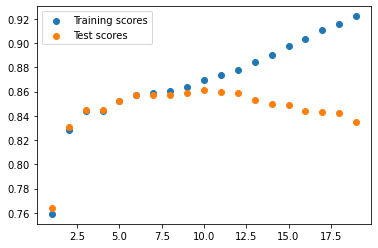

In [15]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(1,20), train_scores, label = "Training scores")
plt.scatter(np.arange(1,20), test_scores, label = "Test scores")
plt.legend()
plt.show()

**Do you see a similar effect here as in Assignment 1?**\
Yes, we see that when the depth increases beyond a certain point, the accuracy for the training set also increases, while the accuracy for the test set decreases. This is due to overfitting.  

**Step 2: Underfitting and overfitting in random forest classifiers.**



In [ ]:
from sklearn.ensemble import RandomForestClassifier

trees_train_scores = []
trees_test_scores = []

pipeline = make_pipeline(
    DictVectorizer(),
    RandomForestClassifier()
)

n_trees = [x for x in range(1,11)] + [x for x in range(11,50, 5)] + [x for x in range(50, 401, 25)]

for trees in n_trees:
    train_scores = []  
    test_scores = []
    print(trees)
    for depth in range(1,30):    
        
        pipeline.set_params(randomforestclassifier__n_estimators = trees, randomforestclassifier__max_depth = depth, randomforestclassifier__n_jobs = -1)
        pipeline.fit(dicts_X_train, Y_train)
        train_scores.append(accuracy_score(Y_train, pipeline.predict(dicts_X_train)))
        test_scores.append(accuracy_score(Y_test, pipeline.predict(dicts_X_test))) 
    
    trees_train_scores.append(train_scores)
    trees_test_scores.append(test_scores)

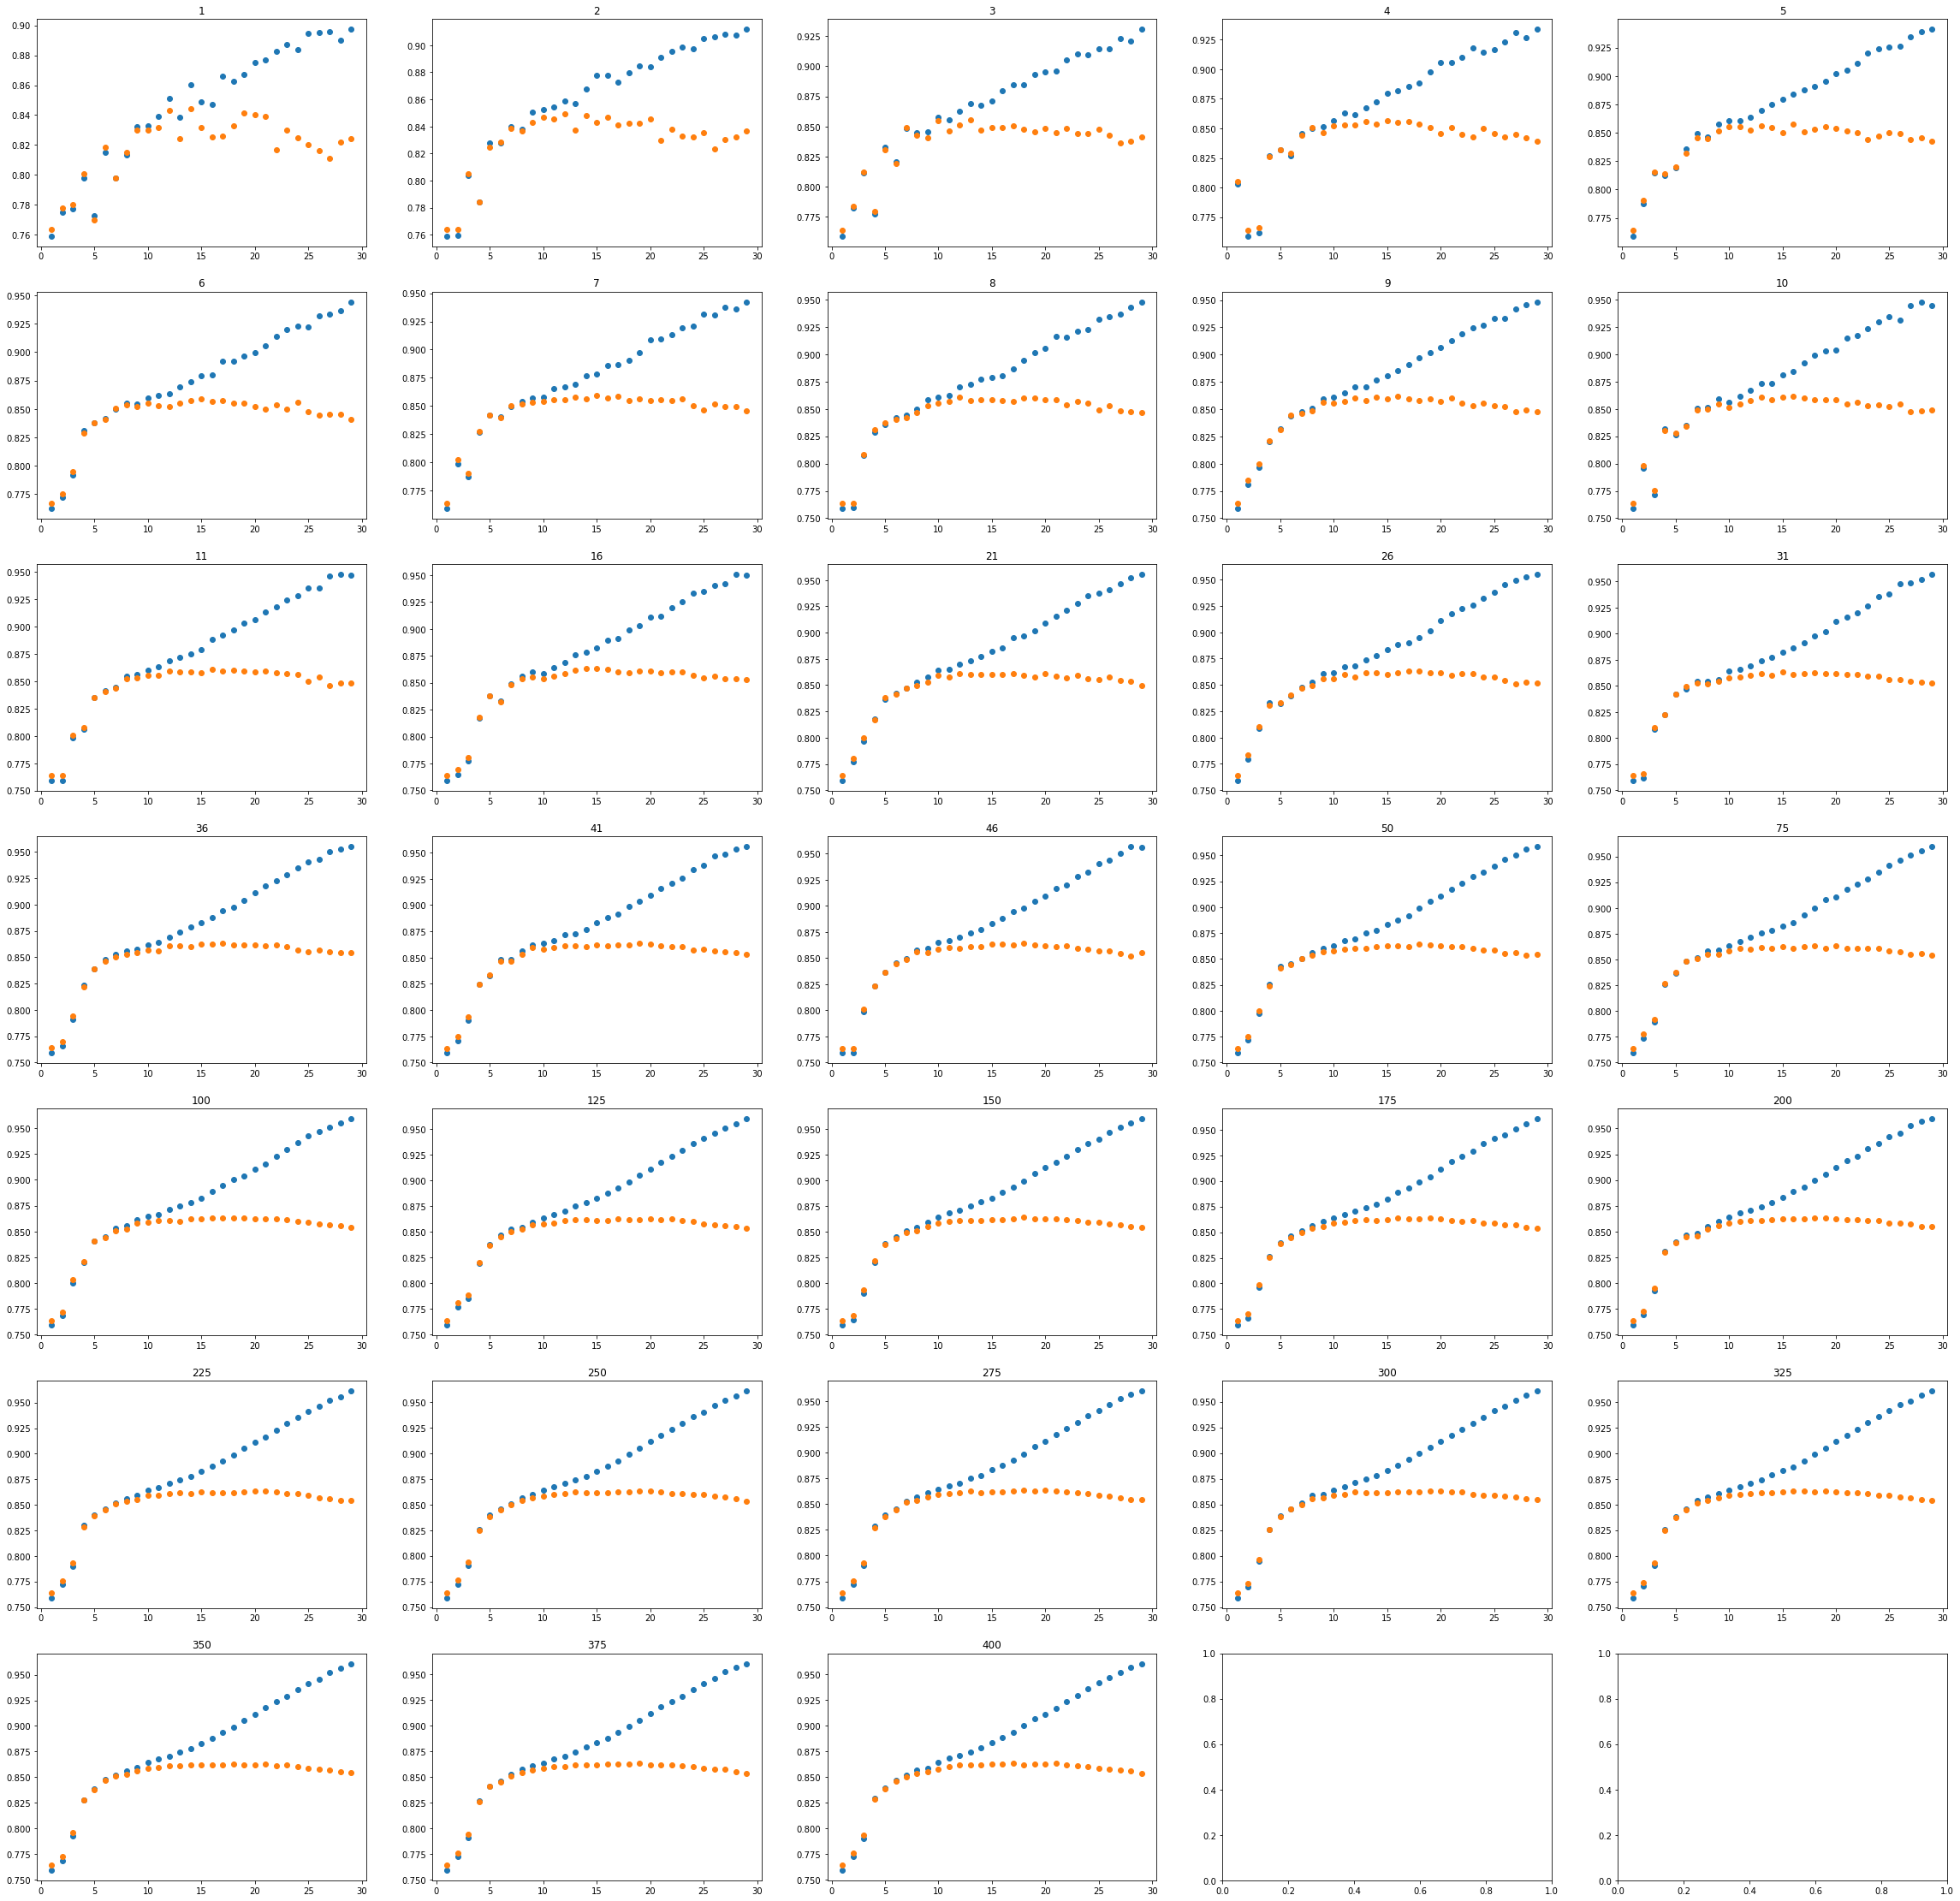

In [19]:
fig, axs = plt.subplots(7, 5, figsize=(40,40))

x = np.arange(1,30)    

index = 0 
for i in range(7):
    for j in range(5):
        if index >= len(trees_test_scores):
            break
        axs[i, j].scatter(x, trees_train_scores[index])
        axs[i, j].scatter(x, trees_test_scores[index])
        axs[i, j].title.set_text(n_trees[index])        
        index += 1

plt.show()

**What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?**\
We can see two main differences between the curve for a decision tree and the curve for a random forest with an ensemble size of 1. Firstly the curve for the random forest is more uneven. For the decision tree the test accuracy increases continuously until a specific point and then starts to decrease. For the random forest, we still see an increasing trend in accuracy when the depth is set to a greater value, but we also see that we get a higher accuracy with for example depth 3 than depth 4. 

The reason for this is that each tree in an ensemble is trained on its own sampled training set (this is called bagging). This means that when we train the random forest with depth 3, it most likely is trained on a different (randomly selected) subset of features than the tree with depth 4. Not all features have the same importance, which means that the accuracy for the different models will differ. The outputs from the trees are aggregated at prediction time, but in this case we only have a single tree in the random forest.

One similarity that we see between the curves for a decision tree and for the random forests is that when the depth is low we get a significantly lower accuary, this is probably due to underfitting.


**What happens with the curve for random forests as the ensemble size grows?** \
When the ensemble size grows, we observe a smoother curve (both for the test set and the training set).


**What happens with the best observed test set accuracy as the ensemble size grows?** \
We notice a small increase in the best test set accuracy as the ensemble size grows, but only until a certain point. Unlike in the case with a single decision tree with a large max depth, we don’t see tendencies of overfitting as the ensemble size grows. Instead the test accuracy seems to stay rather constant. We believe that this is because of bagging: that each tree is trained separately.

**What happens with the training time as the ensemble size grows?**\
The training time for the random forest increases as the number of trees increases. This is because we train each tree separately and therefore have more trees to train when the ensemble is bigger. 


### **Task 3: Feature importances in random forest classifiers**

In [18]:
imp_scores = pipeline.steps[1][1].feature_importances_
feat_names = pipeline.steps[0][1].feature_names_

zipped = list(zip(feat_names,imp_scores))

result = sorted(zipped, key = lambda x: x[1], reverse=True)

# The top 5 features with highest importance score
print(result[0:5])


[('age', 0.17280878188375529), ('capital-gain', 0.12124771159828404), ('hours-per-week', 0.09945734169801089), ('marital-status=Married-civ-spouse', 0.07992659906499958), ('education-num', 0.07252762427235254)]


**Try to reason about why you got this result.** \
The five features with the highest importance score was 
- age
- capital gain
- hours per week
- marital status
- education num

Most of these make sense as they can be factors to decide if a person earns more than 50k a year or not. Age, which is our most important feature, can obviously be a good indicator of someone's income as most people tend to earn more as they get older and more experienced. The rest of the features also feel like they can be good indicators of someone's income. Although the feature ‘marital status’ seems like a surprise for us. We are not sure if this is due to the uncertainty in the calculation of importance scores that Parr et. al mentions, or if it is actually a good indicator for income. 



**For your report, please also mention an alternative way to compute some sort of importance score of individual features.**\
Parr et. al. mentions permutation importance as an alternative way to compute importance scores. To find this you pass a validation set through the random forest, this is used as a baseline. Then, for one of the features, permutate the column and pass all samples through the random forest again. The importance score is then the difference between the baseline accuracy and the drop of accuracy caused by the set with a permuted column. 
